# Tutorial: creating a Q2Q transform from zero

A Q2Q transform is a functional relationship between what you have and what you would like to have. It applies to random variables, because the relationship is between the quantiles of the input and the target random variables.

In this context, this tutorial shows how to generate Q2Q functions between modelled (input) and historical (target) renewable generation time series, for solar and onshore wind power. Unless stated otherwise, hourly time series for one year will be considered.

This Q2Q encapsulates the modelling errors in a statistical sense, and can be used to improve the modelling of renewable generation in tasks related to energy system optimisation. Further details can be found at https://arxiv.org/abs/2412.06571.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np

## Gather your data

To implement a Q2Q transform, you basically need two time series:

- a time series with historical data, $g_{H,t}$, for a specific year of interest.

- a time series with modelled data, $g_{M,t}$, for the same time period.

$t$ refers to time index.

### Historical data

> At the end of this section, the dataframe `df_target` with the input time series must be defined. Indices must be timestamps in UTC, and the column name must be `value`.

Obtaining historical data of renewable generation can be difficult, if not impossible.

Generation time series for Spain can be retrieved at https://api.esios.ree.es/.

This repository includes historical generation time series for Spain for several years in folder `data/historical_data/`

In [2]:
##### Load target data

df_target = pd.read_csv('../data/historical_data/onwind_2023.csv',
                        index_col=0, parse_dates=True)

### Modelled data

> At the end of this section, the dataframe `df_input` with the input time series must be defined. Indices must be timestamps in UTC, and the column name must be `value`.

Wind and solar time series at national level can be modelled with [PyPSA-Eur](https://github.com/PyPSA/pypsa-eur). Here we will use the Spanish extension of this model, [PyPSA-Spain](https://github.com/cristobal-GC/pypsa-spain).

For modelling accuracy, it is important to use an installed capacity layout for the considered technology that is as close as possible to the existing one in the specified year. In **PyPSA-Spain** you can use the functionality `update_elec_capacities` to impose the installed capacity for a specific technology at NUTS 2 level. The data of the installed capacity in Spain at NUTS 2 level can be retrieved at https://www.ree.es/es/apidatos.




It is also important to retain all relevant details and hypotheses of the implemented scenario, as different choices may lead to different generation time series. For example:

- Source of meteorological data

- Wind turbine model / PV panel configuration

- Correction factors

- ...





This repository includes modelled generation time series for Spain for several years in folder `data/historical_data/`. Each file is in the form: 

> {carrier}\_{cutout}\_{year}\_{clustering}.csv


In [3]:
##### Load input data

df_input = pd.read_csv('../data/modelled_data/onwind_iberia_2023_NUTS3.csv',
                        index_col=0, parse_dates=True)

## Compare input and target variables

Have a look at the *pdf*s of both variables.

In [4]:
##### Range for x values
x_max = 1.05*max([df_target.max().max(), df_input.max().max()])
x_min = -0.05*x_max
N = 1000
x_values = np.linspace(x_min, x_max, N)


In [ ]:
##### Input pdf
kde_input = gaussian_kde(df_input['value'])
kde_input.set_bandwidth(bw_method=kde_input.factor * 0.5)  # re-scale bandwidth

pdf_input = kde_input(x_values)

In [ ]:
##### Target pdf
kde_target = gaussian_kde(df_target['value'])
kde_target.set_bandwidth(bw_method=kde_target.factor * 0.5)  # re-scale bandwidth

pdf_target = kde_target(x_values)

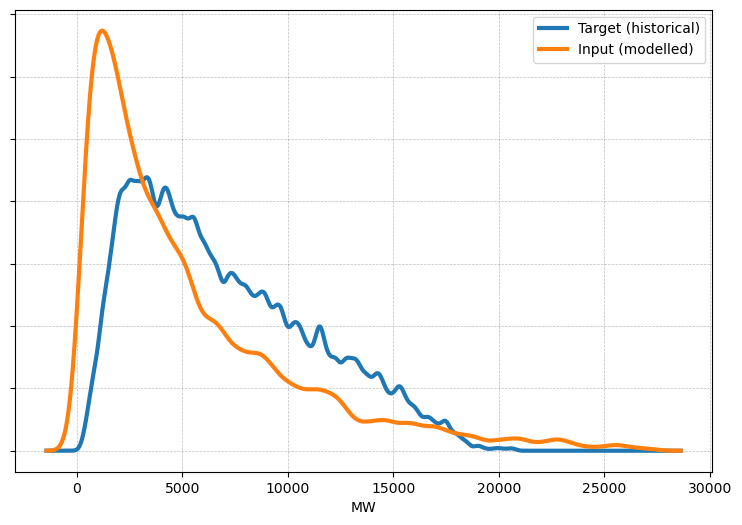

In [42]:
##### Figure
fig, ax = plt.subplots(1,1,figsize=(9,6))

ax.plot(x_values, pdf_target, label='Target (historical)', linewidth=3)
ax.plot(x_values, pdf_input, label='Input (modelled)', linewidth=3)

ax.set_xlabel('MW')
ax.set_yticklabels([])
ax.legend()
ax.grid(True, linestyle='--', linewidth=0.5, color='black', alpha=0.25)


Have a look at the duration curves.

In [28]:
##### Duration curves
sorted_target = df_target['value'].sort_values(ascending=False).reset_index(drop=True)
sorted_input = df_input['value'].sort_values(ascending=False).reset_index(drop=True)

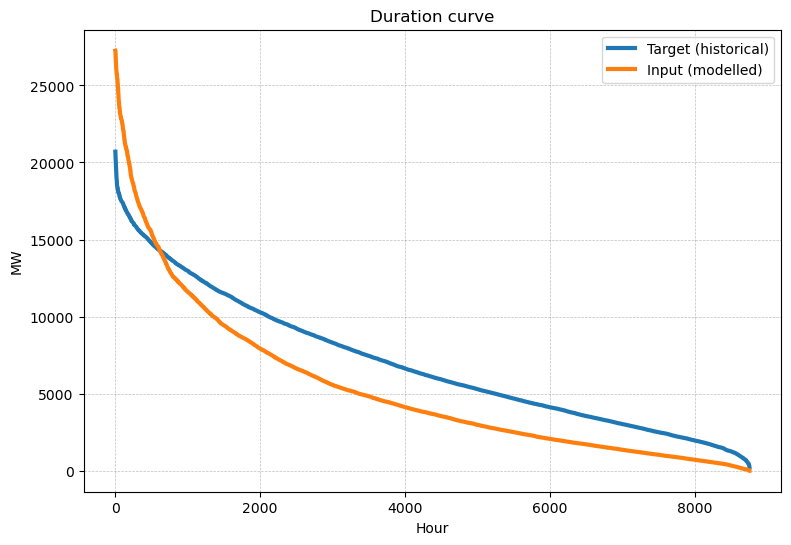

In [44]:
##### Figure
fig, ax = plt.subplots(1,1,figsize=(9,6))

# Graficar en los ejes
ax.plot(sorted_target.values, label='Target (historical)', linewidth=3)
ax.plot(sorted_input.values, label='Input (modelled)', linewidth=3)

# Personalizar
ax.set_title('Duration curve')
ax.set_xlabel('Hour')
ax.set_ylabel('MW')
ax.legend()
ax.grid(True, linestyle='--', linewidth=0.5, color='black', alpha=0.25)


Have a look at the one-to-one plot, using colours to reveal potential seasonalities.

/tmp/ipykernel_31031/4132864393.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


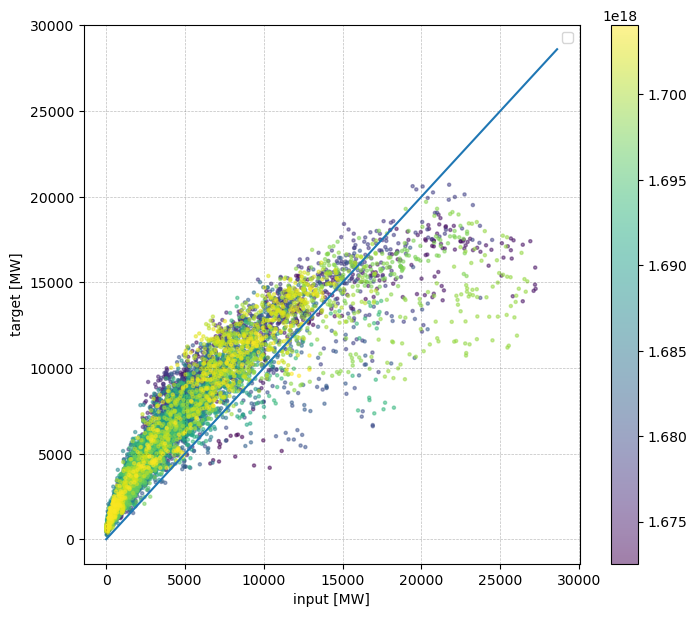

In [45]:
fig, ax = plt.subplots(1,1,figsize=(8,7))

plt.scatter(df_input['value'], df_target['value'], 
            c=pd.to_numeric(df_input.index), ### to explore season dependency
            s = 5,
            alpha=0.5)

### to explore season dependency
cbar = plt.colorbar()

plt.xlabel('input [MW]')
plt.ylabel('target [MW]')
ax.legend()

ax.tick_params(axis='both', which='major')  #, labelsize=labelsize)

# Add grid lines
plt.grid(True, linestyle='--', linewidth=0.5, color='black', alpha=0.25)

# ax.set_title(f'{'value'}: employed data', fontsize=fontsize)

x_max = 1.05*max([df_input.max().max(),df_target.max().max()])
plt.plot([0, x_max],[0, x_max])

